# data

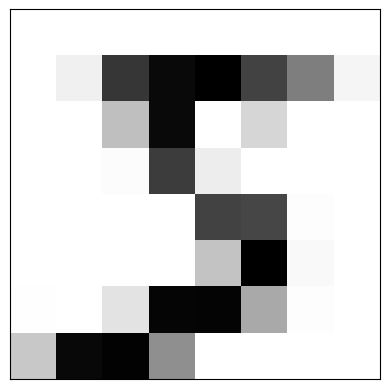

In [1]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

# x_train= data_zoom.x_train
# y_train= data_zoom.y_train
# x_test= data_zoom.x_test
# y_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)
plt.imshow(data_zoom.x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [85]:
# data_zoom.x_train

In [2]:
BIT_WIDTH = 8
EPOCHS = 10
BATCH_SIZE = 32
MODEL_NAME = 'model'

# model class

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from callbacks import all_callbacks
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8
# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=8, flat=True)

class QAutoencoder:
    def __init__(self, data: mnist.MNISTData, bit_width=8, model_name='model'):

        self.x_train = data.x_train
        self.y_train = data.y_train
        self.x_test = data.x_test
        self.y_test = data.y_test
        self.input_min = np.min(data.x_train)
        self.input_max = np.max(data.x_train)
        self.input_shape = (data.x_train.shape[-1],)
        self.BIT_WIDTH = bit_width
        self.MODEL_NAME = model_name
        self.model = self.autoencoder_generator()
        self.history = None
        self.loss = None
        self.float_model_predictions = None

        self.quantized_model_predictions = None
        self.interpreter = None
        self.quantized_tflite_model = None
        self.input_details = None
        self.output_details = None

    def autoencoder_generator(self):

        # Encoder
        encoder_input = Input(shape=self.input_shape)
        encoder_l1 = Dense(64, activation='relu')(encoder_input)
        encoder_l2 = Dense(32, activation='relu')(encoder_l1)
        encoder_l3 = Dense(16, activation='relu')(encoder_l2)
        encoder_output = Dense(2, activation='relu')(encoder_l3)

        # Decoder
        decoder_l1 = Dense(16, activation='relu')(encoder_output)
        decoder_l2 = Dense(32, activation='relu')(decoder_l1)
        decoder_l3 = Dense(32, activation='relu')(decoder_l2)
        # decoder_output = Dense(y_train.shape[-1], activation='sigmoid')(decoder_l3) # classifier
        # decoder_output = Dense(
        #     self.x_train.shape[-1], activation='sigmoid')(decoder_l3)  # autoencoder
        decoder_output = Dense(self.x_train.shape[-1], activation='linear')(decoder_l3)

        # Model
        model = Model(inputs=encoder_input, outputs=decoder_output)
        # refactor the code above to use the functional AP

        model.compile(optimizer='adam', loss='mse')
        # model.compile(optimizer='adam', loss='binary_crossentropy') # classifier
        return model

    def fit_data(self, batch_size=256, epochs=30):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""

        callbacks = all_callbacks(stop_patience=1000,
                                  lr_factor=0.5,
                                  lr_patience=10,
                                  lr_epsilon=0.000001,
                                  # min_delta=0.000001,
                                  lr_cooldown=2,
                                  lr_minimum=0.0000001,
                                  outputDir=f'model/QAE_model{self.BIT_WIDTH}bits/callbacks')
        # callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())

        self.history = self.model.fit(self.x_train, self.x_train,
                                      validation_data=(
                                          self.x_test, self.x_test),
                                      batch_size=batch_size, epochs=epochs,
                                      shuffle=True, callbacks=callbacks.callbacks)
        # self.model = strip_pruning(self.model)
        self.model.save(
            # f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
            f'model/QAE_model{self.BIT_WIDTH}bits/KERAS_check_best_model.h5')
        self.history = self.history.history
        self.loss = self.model.evaluate(self.x_test, self.x_test, verbose=0)
        self.convert_to_tflite()

    def plot_float_model(self, n=6):
        """Plot the float model"""
        
        plt.figure(figsize=(10, 3))
        self.float_model_predictions = self.model.predict(self.x_test)
        self._extracted_from_plot_quantized_model_8(
            n,
            self.float_model_predictions,
            './images/QAE/reconstructed images {model_name}.png',
        )

    # def representative_dataset(self):
    #     for data in self.x_train:
    #         # yield [np.array([data], dtype=np.float32)]
    #         yield [np.array([data * (2 ** (self.BIT_WIDTH - 1))], dtype=np.float32)]

    def representative_dataset(self):
        for data in self.x_train:
            # Scale the data using min and max values
            scaled_data = (data - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))
            yield [np.array([scaled_data], dtype=np.float32)]

    def convert_to_tflite(self):

        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_dataset
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        self.quantized_tflite_model = converter.convert()
        # Save the quantized model
        with open(f'quantized_model.tflite', 'wb') as f:
            f.write(self.quantized_tflite_model)

        # Load the quantized model
        self.interpreter = tf.lite.Interpreter(
            model_path='quantized_model.tflite')
        self.interpreter.allocate_tensors()

        # Get input and output details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.quantized_predictions()

    def quantized_predictions(self, n=6):
        quantized_model_predictions = []

        for i in range(n):
            # Prepare input data
            # input_data = np.array(
            #     [self.x_test[i]*(2**(self.BIT_WIDTH-1))], dtype=np.int8)
            input_data = np.array([(self.x_test[i] - self.input_min) / (self.input_max - self.input_min) * (2 ** (self.BIT_WIDTH - 1))], dtype=np.int8)  

            self.interpreter.set_tensor(
                self.input_details[0]['index'], input_data)
            print(f"input_data: {input_data}")
            # Run inference
            self.interpreter.invoke()

            # Get output
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            output_data = self.interpreter.get_tensor(
                # self.output_details[0]['index']) / (2 ** (self.BIT_WIDTH - 1))
                self.output_details[0]['index'])
            # output_data = output_data * (self.input_max - self.input_min) / (2 ** (self.BIT_WIDTH - 1)) + self.input_min
            output_data = output_data / (2 ** (self.BIT_WIDTH - 1))
            print(f"output_data: {output_data}")
            quantized_model_predictions.append(output_data)
        
        self.quantized_model_predictions = quantized_model_predictions
        # self.compute_mse()

    def plot_quantized_model(self, n=6):

        
        plt.figure(figsize=(10, 3))
        self._extracted_from_plot_quantized_model_8(
            n,
            self.quantized_model_predictions,
            './images/QAE/reconstructed images{model_name}.png',
        )

    # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
    def _extracted_from_plot_quantized_model_8(self, n, quantized_model_predictions, arg3):
        img_size = int(np.sqrt(self.input_shape[0]))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            self.plot_imgs(
                self.x_test, i, img_size, ax
            )
            ax = plt.subplot(2, n, i + n + 1)
            self.plot_imgs(
                quantized_model_predictions, i, img_size, ax
            )
        plt.savefig(arg3.format(model_name=" complete"))
        plt.show()

    # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
    def plot_imgs(self, arg0, i, img_size, ax):
        plt.imshow(arg0[i].reshape(img_size, img_size), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    def compute_mse(self):
        mse = mean_squared_error(self.float_model_predictions, self.quantized_model_predictions)
        print(f'Mean Squared Error between floating point and quantized model predictions: {mse}')
        self.mse = mse

model_obj = QAutoencoder(data_zoom, bit_width=BIT_WIDTH, model_name=MODEL_NAME)
# model.fit(x_train, y_train, epochs=10, batch_size=32) # classifier
model_obj.model.summary()
# model.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE) #autoencoder


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_56 (Dense)            (None, 64)                4160      
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 16)                528       
                                                                 
 dense_59 (Dense)            (None, 2)                 34        
                                                                 
 dense_60 (Dense)            (None, 16)                48        
                                                                 
 dense_61 (Dense)            (None, 32)                544 

# fit data

In [65]:
model_obj.fit_data(epochs=7)  # batch_size=BATCH_SIZE, epochs=EPOCHS)


Epoch 1/7
  1/235 [..............................] - ETA: 9s - loss: 0.0956WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.0050s). Check your callbacks.


231/235 [============================>.] - ETA: 0s - loss: 0.0906
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00001: val_loss improved from inf to 0.08370, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00001: val_loss improved from inf to 0.08370, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00001: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.0905 - val_loss: 0.0837 - lr: 0.0010
Epoch 2/7
230/235 [============================>.] - ETA: 0s - loss: 0.0814
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00002: val_loss improved from 0.08370 to 0.07932, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00002: val_loss improved from 0.08370 to 0.07932, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00002: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00002: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 18ms/step - loss: 0.0814 - val_loss: 0.0793 - lr: 0.0010
Epoch 3/7
223/235 [===========================>..] - ETA: 0s - loss: 0.0788
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00003: val_loss improved from 0.07932 to 0.07709, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00003: val_loss improved from 0.07932 to 0.07709, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00003: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00003: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.0787 - val_loss: 0.0771 - lr: 0.0010
Epoch 4/7
224/235 [===========================>..] - ETA: 0s - loss: 0.0766
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00004: val_loss improved from 0.07709 to 0.07505, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00004: val_loss improved from 0.07709 to 0.07505, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00004: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00004: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 16ms/step - loss: 0.0766 - val_loss: 0.0750 - lr: 0.0010
Epoch 5/7
223/235 [===========================>..] - ETA: 0s - loss: 0.0747
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00005: val_loss improved from 0.07505 to 0.07332, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00005: val_loss improved from 0.07505 to 0.07332, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00005: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00005: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 19ms/step - loss: 0.0747 - val_loss: 0.0733 - lr: 0.0010
Epoch 6/7
235/235 [==============================] - ETA: 0s - loss: 0.0736
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00006: val_loss improved from 0.07332 to 0.07258, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00006: val_loss improved from 0.07332 to 0.07258, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00006: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00006: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 18ms/step - loss: 0.0736 - val_loss: 0.0726 - lr: 0.0010
Epoch 7/7
233/235 [============================>.] - ETA: 0s - loss: 0.0727
***callbacks***
saving losses to model/QAE_model8bits/callbacks\losses.log

Epoch 00007: val_loss improved from 0.07258 to 0.07158, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_best_model.model\assets



Epoch 00007: val_loss improved from 0.07258 to 0.07158, saving model to model/QAE_model8bits/callbacks\KERAS_check_best_model_weights.h5

Epoch 00007: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last.model
INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/callbacks\KERAS_check_model_last.model\assets



Epoch 00007: saving model to model/QAE_model8bits/callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 18ms/step - loss: 0.0727 - val_loss: 0.0716 - lr: 0.0010
INFO:tensorflow:Assets written to: model/QAE_model8bits/KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: model/QAE_model8bits/KERAS_check_best_model.model\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmp7wqsa8m0\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmp7wqsa8m0\assets


input_data: [[   0    0    0    0    0    0    0    0    0   56   34    0    0    0
     0    0    0   24   31   89   92   71  118    0    0    0    0    0
     0   76   18    0    0    0    0    0    0  127    1    0    0    0
     0    0   92   15    0    0    0    0    0   13  102    1    0    0
     0    0    0 -128    0    0    0    0]]
output_data: [[-0.4609375 -0.4921875 -0.421875  -0.390625  -0.2578125 -0.2109375
  -0.421875  -0.4609375 -0.4921875 -0.4609375 -0.2734375  0.1171875
   0.21875    0.1015625 -0.1328125 -0.4375    -0.5       -0.59375
  -0.1171875 -0.203125  -0.4453125 -0.3515625 -0.1015625 -0.390625
  -0.484375  -0.359375   0.234375  -0.1875    -0.265625  -0.1171875
  -0.0078125 -0.4453125 -0.40625   -0.1796875  0.3203125  0.046875
  -0.109375   0.015625   0.0703125 -0.4140625 -0.4609375 -0.109375
   0.03125   -0.2890625 -0.265625   0.1484375  0.046875  -0.515625
  -0.40625   -0.0859375  0.015625  -0.109375   0.125      0.109375
  -0.359375  -0.46875   -0.4140625 -0.

# plot

In [66]:
# def plot_quantized_model(obj, n=6):
#     quantized_model_predictions = []
#     # test_imgs = x_train
#     test_imgs = obj.x_test

#     for i in range(n):
#         # Prepare input data
#         input_data = np.array(
#             [test_imgs[i]*(2**(obj.BIT_WIDTH-1))], dtype=np.int8)
#         obj.interpreter.set_tensor(
#             obj.input_details[0]['index'], input_data)
#         # print(f"input_data: {input_data}")
#         # Run inference
#         obj.interpreter.invoke()

#         # Get output
#         # output_data = interpreter.get_tensor(output_details[0]['index'])
#         output_data = obj.interpreter.get_tensor(
#             # obj.output_details[0]['index']) / (2 ** (obj.BIT_WIDTH - 1))
#             obj.output_details[0]['index'])
#         print(f"output_data: {output_data}")
#         quantized_model_predictions.append(output_data)
#         print("------------------ \n")

#     plt.figure(figsize=(10, 3))
#     obj._extracted_from_plot_quantized_model_8(
#         n,
#         test_imgs,
#         quantized_model_predictions,
#         './images/QAE/reconstructed images{model_name}.png',
#     )

# # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
# def _extracted_from_plot_quantized_model_8(obj, n, test_imgs, quantized_model_predictions, arg3):
#     img_size = int(np.sqrt(obj.input_shape[0]))
#     for i in range(n):
#         ax = plt.subplot(2, n, i + 1)
#         obj.plot_imgs(
#             test_imgs, i, img_size, ax
#         )
#         ax = plt.subplot(2, n, i + n + 1)
#         obj.plot_imgs(
#             quantized_model_predictions, i, img_size, ax
#         )
#     plt.savefig(arg3.format(model_name=" complete"))
#     plt.show()

# # TODO Rename this here and in `plot_float_model` and `plot_quantized_model`
# def plot_imgs(obj, arg0, i, img_size, ax):
#     plt.imshow(arg0[i].reshape(img_size, img_size), cmap='gray_r')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

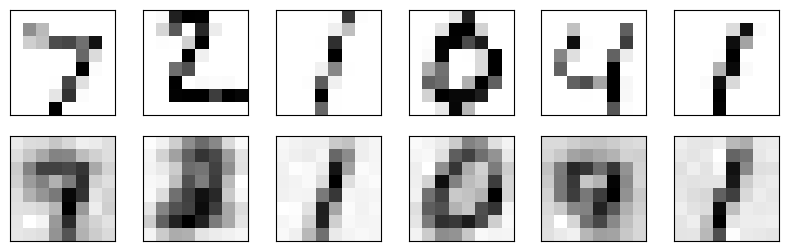

In [67]:
model_obj.plot_float_model()

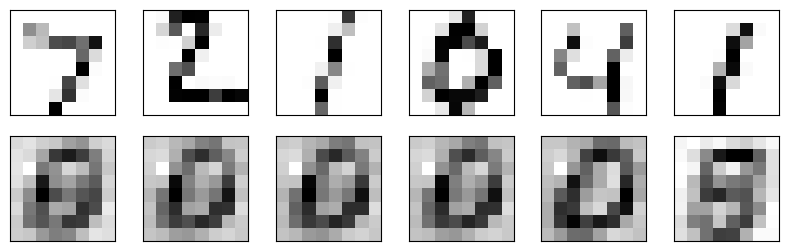

In [68]:
# obj = model_obj
# plot_quantized_model(obj, n=6)
model_obj.plot_quantized_model(n=6)

In [69]:
model_obj.float_model_predictions[0]

array([-0.02150068,  0.0156076 ,  0.02179566,  0.07375401,  0.02924037,
       -0.03326507, -0.02505459,  0.00884648,  0.01045914,  0.07307841,
        0.15243047,  0.2476467 ,  0.2417716 ,  0.09657636,  0.04357026,
        0.00994353,  0.05986412,  0.251407  ,  0.42270425,  0.42253816,
        0.4069883 ,  0.45535773,  0.15133089,  0.03943221,  0.04784808,
        0.18330134,  0.25623325,  0.13010374,  0.27085775,  0.4764258 ,
        0.04859004,  0.00758731,  0.00995792,  0.12882039,  0.20396416,
        0.27546817,  0.5731055 ,  0.46107057, -0.00384685,  0.03705094,
        0.00364595,  0.00687055,  0.02548716,  0.11691193,  0.5974051 ,
        0.19131678, -0.02907322,  0.0494942 , -0.01148535, -0.07801425,
       -0.04677773,  0.19116828,  0.48137936,  0.11250585,  0.0366061 ,
       -0.00138363, -0.0136549 , -0.00297997,  0.00766612,  0.20607652,
        0.37499186,  0.12558827,  0.05858274,  0.02201036], dtype=float32)

In [70]:
model_obj.quantized_model_predictions[0]

array([[-0.4609375, -0.4921875, -0.421875 , -0.390625 , -0.2578125,
        -0.2109375, -0.421875 , -0.4609375, -0.4921875, -0.4609375,
        -0.2734375,  0.1171875,  0.21875  ,  0.1015625, -0.1328125,
        -0.4375   , -0.5      , -0.59375  , -0.1171875, -0.203125 ,
        -0.4453125, -0.3515625, -0.1015625, -0.390625 , -0.484375 ,
        -0.359375 ,  0.234375 , -0.1875   , -0.265625 , -0.1171875,
        -0.0078125, -0.4453125, -0.40625  , -0.1796875,  0.3203125,
         0.046875 , -0.109375 ,  0.015625 ,  0.0703125, -0.4140625,
        -0.4609375, -0.109375 ,  0.03125  , -0.2890625, -0.265625 ,
         0.1484375,  0.046875 , -0.515625 , -0.40625  , -0.0859375,
         0.015625 , -0.109375 ,  0.125    ,  0.109375 , -0.359375 ,
        -0.46875  , -0.4140625, -0.390625 , -0.2265625, -0.1328125,
        -0.1640625, -0.359375 , -0.5      , -0.4765625]])

In [90]:
model_obj.x_test[0].shape

(64,)

# new load

In [91]:
import numpy as np
import tensorflow as tf
import tensorflow.lite as tflite

class Model:
    def __init__(self, data: mnist.MNISTData, BIT_WIDTH=8):
        self.BIT_WIDTH = BIT_WIDTH
        self.load_model()
        # self.load_test_data()
        self.x_train = data.x_train
        self.y_train = data.y_train
        self.x_test = data.x_test
        self.y_test = data.y_test

        self.float_predictions()
        self.quantize_model()
        self.quantized_predictions()

    def load_model(self):
        self.model = tf.keras.models.load_model(f'model/QAE_model8bits/KERAS_check_best_model.model')

    # def load_test_data(self):
        # (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.mnist.load_data()
        # self.x_test = self.x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255

    def float_predictions(self, n=6):
        self.float_model_predictions = [self.model.predict(self.x_test[i:i+1]) for i in range(n)]

    def representative_dataset(self):
        for data in self.x_train:
            # yield [np.array([data], dtype=np.float32)]
            # print(f"data: {data* (2 ** (self.BIT_WIDTH - 1))}")
            yield [np.array([data * (2 ** (self.BIT_WIDTH - 1))], dtype=np.float32)]

    def quantize_model(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_dataset
        converter.target_spec.supported_types = [tf.int8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        tflite_quantized_model = converter.convert()
        with open('quantized_model.tflite', 'wb') as f:
            f.write(tflite_quantized_model)

        self.interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.interpreter.allocate_tensors()


    def quantized_predictions(self, n=6):
        quantized_model_predictions = []
        input_shape = self.input_details[0]['shape']

        for i in range(n):
            # Prepare input data
            input_data = np.array(self.x_test[i] * 255, dtype=np.int8).reshape(input_shape)
            self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

            # Run inference
            self.interpreter.invoke()

            # Get output
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            output_data = output_data.astype(np.float32) / 255
            quantized_model_predictions.append(output_data)

        self.quantized_model_predictions = quantized_model_predictions

model_obj = Model(data = data_zoom)


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmpx6jk1rd8\assets


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmpx6jk1rd8\assets


In [102]:
model_obj.float_model_predictions[0]*128

array([[-2.752086  ,  1.997776  ,  2.7898467 ,  9.44052   ,  3.7427683 ,
        -4.2579236 , -3.2069857 ,  1.1323516 ,  1.338767  ,  9.354033  ,
        19.511097  , 31.698778  , 30.946756  , 12.361761  ,  5.5769844 ,
         1.2727685 ,  7.662607  , 32.18009   , 54.106125  , 54.084885  ,
        52.09451   , 58.28578   , 19.370346  ,  5.0473223 ,  6.1245546 ,
        23.462564  , 32.79785   , 16.653275  , 34.669796  , 60.982483  ,
         6.219524  ,  0.9711714 ,  1.2746134 , 16.489004  , 26.107405  ,
        35.25992   , 73.35751   , 59.01702   , -0.49239063,  4.742521  ,
         0.4666829 ,  0.8794317 ,  3.2623491 , 14.964722  , 76.46785   ,
        24.488543  , -3.72138   ,  6.3352547 , -1.4701275 , -9.985825  ,
        -5.987548  , 24.469536  , 61.616566  , 14.400737  ,  4.6855793 ,
        -0.17710257, -1.7478358 , -0.3814392 ,  0.98126054, 26.37778   ,
        47.998955  , 16.075287  ,  7.4985876 ,  2.8173275 ]],
      dtype=float32)

In [103]:
model_obj.quantized_model_predictions[0]*128

array([[-30.619608 , -31.121569 , -26.603922 , -24.094118 , -10.541177 ,
        -10.039216 , -27.607843 , -29.113726 , -32.125492 , -34.133335 ,
        -28.109804 ,  -2.0078433,   9.537255 ,   0.       ,  -8.533334 ,
        -30.619608 , -31.121569 , -42.666668 , -19.576471 ,  -8.533334 ,
        -24.596079 , -35.137257 ,  -6.5254903, -20.580393 , -28.611765 ,
        -26.603922 ,   8.031373 , -11.043138 , -24.596079 , -36.14118  ,
          3.5137255, -24.596079 , -27.607843 ,  -7.027451 ,   1.5058824,
        -21.584314 , -30.117647 , -30.117647 ,  12.047059 , -23.592157 ,
        -25.09804  ,   3.0117648,  -1.0039216, -28.611765 , -34.635296 ,
         -3.5137255,   9.035295 , -32.627453 , -25.6      ,   1.5058824,
         12.047059 ,  -1.0039216,   6.5254903,   2.509804 , -24.094118 ,
        -30.619608 , -28.109804 , -21.082354 , -10.541177 , -10.039216 ,
        -22.588236 , -34.133335 , -32.125492 , -30.117647 ]],
      dtype=float32)

In [101]:
model_obj.float_model_predictions[0] - model_obj.quantized_model_predictions[0]

array([[ 0.21771501,  0.2587449 ,  0.22963881,  0.26198936,  0.11159332,
         0.04516635,  0.1906317 ,  0.23629747,  0.26143953,  0.33974507,
         0.3720383 ,  0.263333  ,  0.16726172,  0.09657626,  0.11023686,
         0.24915919,  0.30300137,  0.5847403 ,  0.57564527,  0.48920482,
         0.59914523,  0.72986746,  0.20231122,  0.20021653,  0.2713775 ,
         0.39114442,  0.19348812,  0.21637821,  0.46301466,  0.7587786 ,
         0.02113905,  0.19974414,  0.2256442 ,  0.1837223 ,  0.1921994 ,
         0.44409555,  0.8083997 ,  0.6963646 , -0.09796445,  0.22136468,
         0.19972439, -0.01665885,  0.03333024,  0.3404413 ,  0.86799335,
         0.21876772, -0.09966152,  0.30439615,  0.18851463, -0.08977896,
        -0.14089537,  0.19901139,  0.43039903,  0.09289791,  0.22484139,
         0.23783207,  0.20595288,  0.1617259 ,  0.09001904,  0.28450778,
         0.5514624 ,  0.39225486,  0.30956313,  0.2573045 ]],
      dtype=float32)

# others

In [92]:
# # Get the weights and biases of the loaded model
# for layer in model.layers:
#     weights = layer.get_weights()
#     print(f'Layer {layer.name}:')
#     # print(f'max {max(weights)}:')
    
#     if len(weights) == 2:
#         w, b = weights
#         print(f'  Weights:\n{w}')
#         # print(f'max {max(w)}:')
#         print(f'  Biases:\n{b}')
#     else:
#         print('  No weights and biases.')

In [93]:
# def representative_dataset():
#     for data in x_train:
#         # yield [np.array([data], dtype=np.float32)]
#         yield [np.array([data * (2 ** (BIT_WIDTH - 1))], dtype=np.float32)]


# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

# quantized_tflite_model = converter.convert()



In [94]:
# PARAMETERS_NAME = f"{BIT_WIDTH}bit_quantized_{loss}loss"

In [95]:
# # Save the saved quantized weights
# model.save_weights('quantized_weights.h5')

# # Load the saved quantized weights
# model.load_weights('quantized_weights.h5')

In [96]:
# # Save the quantized model
# with open(f'quantized_model.tflite', 'wb') as f:
#     f.write(quantized_tflite_model)

# # Load the quantized model
# interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
# interpreter.allocate_tensors()

# # Get input and output details
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()


In [97]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model

# model = autoencoder_generator(x_train)

# # Load the saved quantized weights
# model.load_weights('quantized_weights.h5')
# # model.fit(x_train, y_train, epochs=10, batch_size=32)